<a href="https://colab.research.google.com/github/grawoods/teamA-grebes-NMA2020/blob/master/GW_TemporalFilter_GaussianGLM_allNeurons.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title Data retrieval
import os
import requests

fname = "stringer_spontaneous.npy"
url = "https://osf.io/dpqaj/download"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)

In [2]:
#@title Data loading
import numpy as np
dat = np.load('stringer_spontaneous.npy', allow_pickle=True).item()
print(dat.keys())

dict_keys(['sresp', 'run', 'beh_svd_time', 'beh_svd_mask', 'stat', 'pupilArea', 'pupilCOM', 'xyz'])


In [3]:
#@title import matplotlib and set defaults
#%matplotlib notebook <--- use this for jupyter notebook!!!
from matplotlib import rcParams 
from matplotlib import pyplot as plt
rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] =15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

In [4]:
def make_design_matrix(stim, d=20):
    """Create time-lag design matrix from stimulus intensity vector.

    Args:
    stim (1D array): Stimulus intensity at each time point.
    d (number): Number of time lags to use.

    Returns
    X (2D array): GLM design matrix with shape T, d

    """
    # Create version of stimulus vector with zeros before onset
    pad = round(d/2)
    padded_stim = np.concatenate([np.zeros(pad-1), stim, np.zeros(pad)])
    # Construct a matrix where each row has the d frames of
    # the stimulus proceeding and including timepoint t
    T = len(stim)  # Total number of timepoints (hint: total number of stimulus frames)
    X = np.zeros((T, d))
  
    for t in range(T):
        X[t] = padded_stim[t:t+d]

    return X

def plot_time_filter(theta, dt, **kws):
    """Plot estimated weights based on time lag model.

    Args:
    theta (1D array): Filter weights, not including DC term.
    dt (number): Duration of each time bin.
    kws: Pass additional keyword arguments to plot()

    """
    d = len(theta)
    t = np.arange(-round(d/2) + 1, round(d/2)+1) * dt

    ax = plt.gca()
    ax.plot(t, theta, marker="o", **kws)
    ax.axhline(0, color=".2", linestyle="--", zorder=1)
    ax.set(
        xlabel="Time relative to Run (s)",
        ylabel="Filter weight",
      )

def sorting_alg(theta_zscore, types,**kws):
    ''' 
    Simple sorting procedure to extract high- and low-level activity of neurons 
    '''
    if types=='max':
        s = np.argmax(theta_zscore,1)
    # if types=='mean':
    #   s = np.mean(theta_zscore,1)
    else:
        s = np.argmin(theta_zscore,1)
    s = sorted(range(len(s)), key=lambda k: s[k])
    return s

def perform_MLE(X, N_neuron, time_duration, training_len, **kws):
    theta_lg_store = np.zeros((N_neuron,time_duration))
    X = X[:,:training_len]
    y = [x[0] for x in dat['run'][:training_len]]
    
    for neuron_idx in range(0,N_neuron):
        X_dm = make_design_matrix(X[neuron_idx,:],time_duration)
        constant = np.ones_like(y)
        X_dm = np.column_stack([constant, X_dm])
    
        # Get MLE weights for LG model
        theta = np.linalg.inv(X_dm.T@X_dm) @ X_dm.T @ y
        theta_lg = theta[1:]
        theta_lg_store[neuron_idx,:] = theta_lg
        
    return theta_lg_store

In [5]:
N_neuron = len(dat['sresp']) # number of neurons from Ca2+ activity
training_len = 5000
time_duration = 26 #total duration of temporal filter, with half before, and half after running output
theta_lg_store2 = np.zeros((N_neuron,time_duration))
X = dat['sresp']

theta_lg_store = perform_MLE(X,N_neuron,time_duration,training_len)

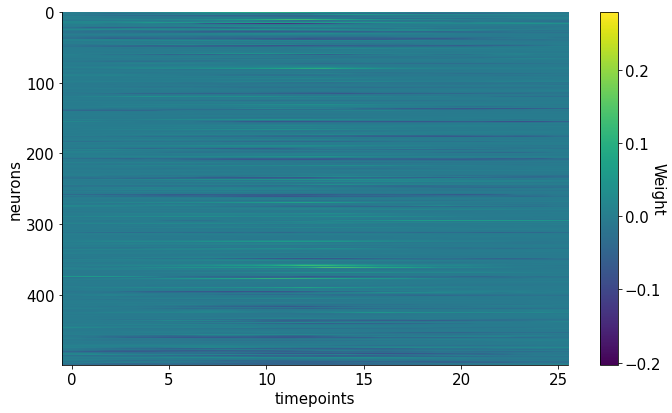

In [6]:
N = 500 # number of neurons for plotting
stop_len = 7018 #cut-off index for plotting time-trace

plt.figure(figsize=(10,6))
plt.imshow(theta_lg_store[:N,:stop_len], aspect = 'auto',cmap = 'viridis')
plt.xlabel('timepoints')
plt.ylabel('neurons')
cbar = plt.colorbar()
cbar.set_label('Weight', rotation=270)
plt.show()

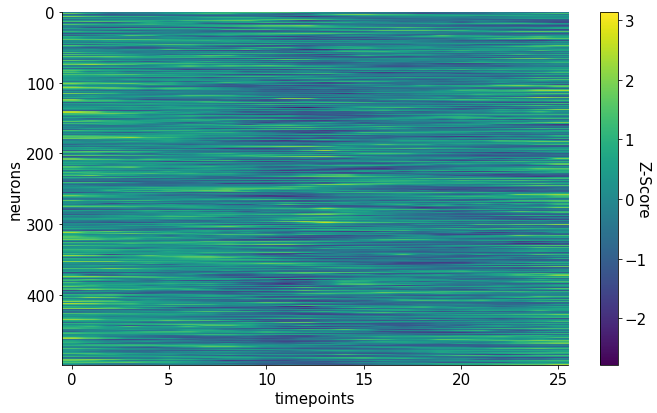

In [7]:
from scipy.stats import zscore

theta_zscore = zscore(theta_lg_store, axis=1)
N = 500 # number of neurons for plotting
stop_len = 7018 #cut-off index for plotting time-trace

plt.figure(figsize=(10,6))
plt.imshow(theta_zscore[:N,:stop_len], aspect = 'auto',cmap = 'viridis')
plt.xlabel('timepoints')
plt.ylabel('neurons')
cbar = plt.colorbar()
cbar.set_label('Z-Score', rotation=270)

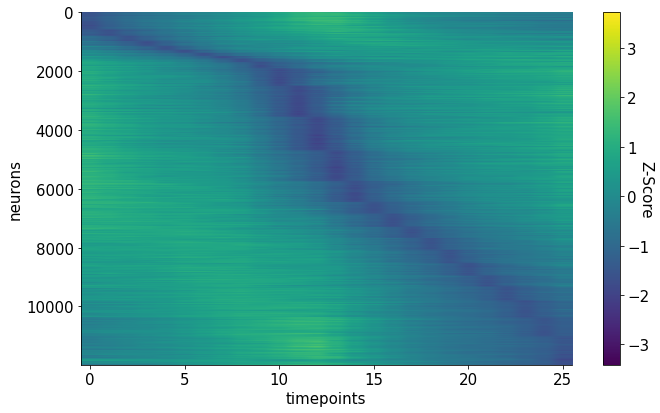

In [8]:
#@title Minimum Population Activity (Sorted)

s_min = sorting_alg(theta_zscore,types='min')

plt.figure(figsize=(10,6))
plt.imshow(theta_zscore[s_min,:stop_len], aspect = 'auto',cmap = 'viridis')
plt.xlabel('timepoints')
plt.ylabel('neurons')
cbar = plt.colorbar()
cbar.set_label('Z-Score', rotation=270)

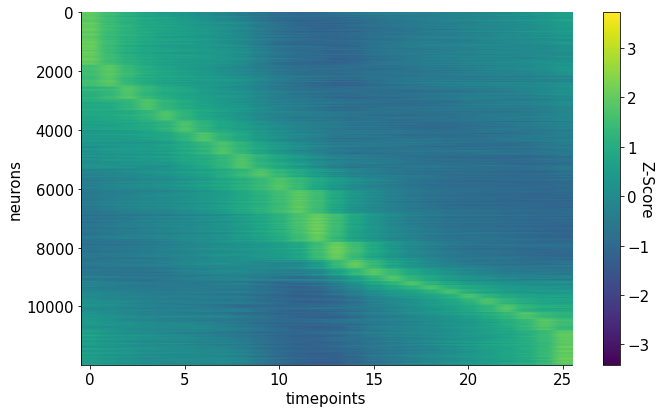

In [9]:
#@title Maximum Population Activity (Sorted)

s_min = sorting_alg(theta_zscore,types='max')

plt.figure(figsize=(10,6))
plt.imshow(theta_zscore[s_min,:stop_len], aspect = 'auto',cmap = 'viridis')
plt.xlabel('timepoints')
plt.ylabel('neurons')
cbar = plt.colorbar()
cbar.set_label('Z-Score', rotation=270)

In [10]:
s = sorting_alg(theta_zscore,types='min')

s_idx = np.column_stack([range(0,N_neuron), s])

location_store = np.zeros((N_neuron,3))

for neuron_idx in range(0,N_neuron):
    location_store[neuron_idx,:] = dat['xyz'][:,neuron_idx]

idx_rank_location = np.column_stack([s_idx, location_store])

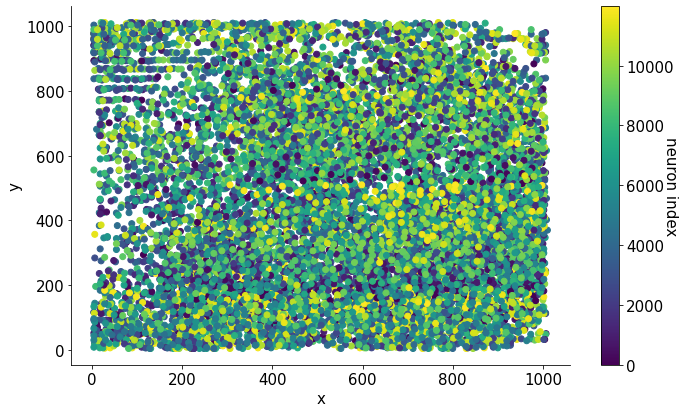

In [11]:
# @title Overlay of all 2D planes; Sorted by Min Activity

plt.figure(figsize=(10,6))
ax = plt.subplot(1,1,1)
plt.scatter(idx_rank_location[ : ,2:3], idx_rank_location[ : ,3:4], c= idx_rank_location[ : ,1:2])
ax.set(xlabel = 'x', ylabel = 'y')
cbar = plt.colorbar()
cbar.set_label('neuron index', rotation=270)

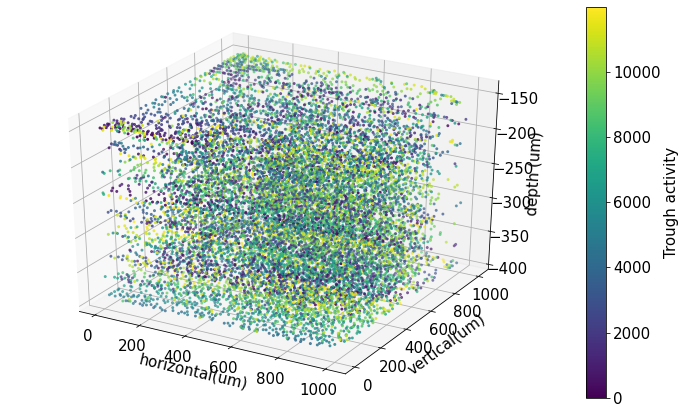

In [12]:
#@title 3D plot of neurons with color-coded activity

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111, projection='3d')
p = ax.scatter(idx_rank_location[:,2:3],idx_rank_location[:,3:4],idx_rank_location[:,4:5],'o', s = 4, c = idx_rank_location[:,1:2])
fig.colorbar(p, label = 'Trough activity')
ax.set(xlabel='horizontal(um)', ylabel = 'vertical(um)', zlabel='depth (um)')
plt.show()